In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(41)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Self-interaction of all 3 given shapes can be learnt by one 3-layer NN. Accuracy is really good. Please note it's just 3 shapes of 3 types, we didn't vary axis sizes for any a,b,c values for any particular shape.

This is not something we tried for two-body case (single NN for multiple shapes, or even similar shape but different a,b,c).

In [2]:
def compute_rotvec_batch(rot_partial_flat):
    N = rot_partial_flat.shape[0]
    R_partial = rot_partial_flat.reshape(N, 3, 2)
    R3 = np.cross(R_partial[:, :, 0], R_partial[:, :, 1])
    R_full = np.concatenate((R_partial, R3[:, :, np.newaxis]), axis=2)  # shape (N,3,3)
    rotvecs = Rotation.from_matrix(R_full).as_rotvec()  # shape (N,3)
    return rotvecs

def rotate_forces_torques_to_body(forces_lab, torques_lab, rotvec):
    """
    Rotate forces & torques from lab frame to the body frame (which we'll
    assume is aligned with the spheroid's major axis = z-axis in the body frame).
    
    forces_lab, torques_lab, rotvec all have shape (N,3).
    """
    # Create a batch of Rotation objects from each rotvec
    rot = Rotation.from_rotvec(rotvec)   # shape: (N,) - a stack of N rotations
    
    # 'inverse=True' rotates vectors *into* the body frame
    forces_body = rot.apply(forces_lab, inverse=True)
    torques_body = rot.apply(torques_lab, inverse=True)
    
    return forces_body, torques_body

In [3]:
times = ['12:47', '13:48','13:52', '14:18', '14:22']

xs,ys = [],[]
for t in times:
    x = np.load(f"../data/X_self_{t}.npy")
    y = np.load(f"../data/Y_self_{t}.npy")

    xs.append(x)
    ys.append(y)

xs.append(np.load("../data/X_self_oblateSpheroid_21:28.npy"))
ys.append(np.load("../data/Y_self_oblateSpheroid_21:28.npy"))

xs.append(np.load("../data/X_self_sphere_21:10.npy"))
ys.append(np.load("../data/Y_self_sphere_21:10.npy"))

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)
orient = compute_rotvec_batch(X[:,3:9]) # convert rotation matrix to vector

# we'll project force and torque to "body frame" (major axis z-axis algined)
# This way, we can ignore particle's orientation for mobility calculation
# We will have to project velocity back to "lab frame" later- after M @ F.
f,t = rotate_forces_torques_to_body(X[:, 9:12], X[:, 12:15], orient)
Y[:, :3], Y[:, 3:] = rotate_forces_torques_to_body(Y[:, :3], Y[:, 3:], orient)
X[:, 9:12], X[:, 12:15] = f, t


# remove abc
# x = x[:, 3:]

X = torch.Tensor(X).to(device)
Y = torch.Tensor(Y).to(device)
#orient = torch.Tensor(orient).to(device) 

X.shape, Y.shape

(torch.Size([47000, 15]), torch.Size([47000, 6]))

In [4]:
def shuffle(*arrays):
    # Ensure that all arrays have the same first dimension.
    n = arrays[0].shape[0]
    idx = torch.randperm(n)
    return tuple(arr[idx] for arr in arrays)

X, Y = shuffle(X,Y)

split_frac = .8
split_point = int(split_frac * X.size(0))

X_train, X_val = X[:split_point], X[split_point:]
Y_train, Y_val = Y[:split_point], Y[split_point:]
#orient_train, orient_val = orient[:split_point], orient[split_point:]

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([37600, 15]),
 torch.Size([9400, 15]),
 torch.Size([37600, 6]),
 torch.Size([9400, 6]))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfNetwork(nn.Module):
    """
    Neural network that predicts the 4 key self-mobility scalars for an
    axisymmetric particle in Stokes flow:
       mu_T_parallel, mu_T_perp, mu_R_parallel, mu_R_perp
    """
    def __init__(self, input_dim):
        super(SelfNetwork, self).__init__()
        
        # Example architecture. You can tweak layer sizes or add more layers as needed.
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            #nn.Tanh()
        )

    def forward(self, x):
        """
        x includes whatever parameters you need to predict the mobility
        scalars (e.g. aspect ratio, orientation in some parameterization, etc.)
        Returns the 4 scalars: [mu_T_para, mu_T_perp, mu_R_para, mu_R_perp].
        """
        return self.layers(x)

    def predict_velocity(self, x, force):
        """
        force:  tensor of shape (batch_size, 6) -> [Fx, Fy, Fz, Tx, Ty, Tz]
        
        Steps:
        1) Forward pass to get the 4 mobility scalars.
        2) Construct the diagonal 3x3 blocks M^{TT}, M^{RR} because
           the particle's major axis is z-axis.
        3) Multiply by force => velocity [Ux, Uy, Uz, Ox, Oy, Oz].
        """
        # 1) Get the mobility scalars
        mus = self.forward(x)  # shape (batch_size, 4)
        mu_T_para = mus[:, 0]  # (batch_size,)
        mu_T_perp = mus[:, 1]
        mu_R_para = mus[:, 2]
        mu_R_perp = mus[:, 3]

        F_3    = force[:, 0:3]  # (batch_size, 3)
        tau_3  = force[:, 3:6]  # (batch_size, 3)

        # 2) For each sample, build M^{TT} and M^{RR} as diag:
        #    M^{TT} = diag(mu_T_perp, mu_T_perp, mu_T_para)
        #    M^{RR} = diag(mu_R_perp, mu_R_perp, mu_R_para)
        # We'll do it in a batched way:
        
        # expand dims for broadcasting
        mu_T_para_ = mu_T_para.view(-1, 1)  # (batch_size,1)
        mu_T_perp_ = mu_T_perp.view(-1, 1)
        mu_R_para_ = mu_R_para.view(-1, 1)
        mu_R_perp_ = mu_R_perp.view(-1, 1)

        # velocity in the z-axis aligned frame:
        #   Ux = mu_T_perp * Fx
        #   Uy = mu_T_perp * Fy
        #   Uz = mu_T_para * Fz
        Ux = mu_T_perp_ * F_3[:,0:1]
        Uy = mu_T_perp_ * F_3[:,1:2]
        Uz = mu_T_para_ * F_3[:,2:3]

        # angular velocity:
        #   Ox = mu_R_perp * Tx
        #   Oy = mu_R_perp * Ty
        #   Oz = mu_R_para * Tz
        Ox = mu_R_perp_ * tau_3[:,0:1]
        Oy = mu_R_perp_ * tau_3[:,1:2]
        Oz = mu_R_para_ * tau_3[:,2:3]

        U = torch.cat([Ux, Uy, Uz], dim=1)       # (batch_size, 3)
        Omega = torch.cat([Ox, Oy, Oz], dim=1)   # (batch_size, 3)

        # Combine
        velocity = torch.cat([U, Omega], dim=1)  # (batch_size, 6)
        return velocity

In [7]:
# class SelfNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(SelfNetwork, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.Relu(),
#             nn.Linear(128, 6),
#         )

#     def forward(self, r):
#         return self.layers(r)


input_dim = 9 # a,b,c and orientation
batch_size = 256
epochs = 200
model = SelfNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.L1Loss()
n_iter = X_train.shape[0]//batch_size
n_iter, n_iter*batch_size, len(X_train)

(146, 37376, 37600)

In [8]:
losses = []
for epoch in range(epochs):
    model.train()
    avg = 0

    X_train, Y_train = shuffle(X_train, Y_train) #dont forget orient if it comes back
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        X_batch = X_train[indices, :9]
        F_batch = X_train[indices, 9:]
        #orient_batch = orient_train[indices]
        Y_batch = Y_train[indices]
        
        batch_output = model.predict_velocity(X_batch, F_batch)

        # Compute loss
        loss = criterion(batch_output, Y_batch)
        
        loss.backward()
        avg += loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)

torch.save(model.state_dict(), "self_interaction.wt")

Epoch 0, Loss: 0.04313357009820334
Epoch 5, Loss: 0.006652903371516054
Epoch 10, Loss: 0.004283305709664901
Epoch 15, Loss: 0.0034752544422302243
Epoch 20, Loss: 0.002807480781434793
Epoch 25, Loss: 0.002859248723101177
Epoch 30, Loss: 0.002278891532388452
Epoch 35, Loss: 0.0028692608211215026
Epoch 40, Loss: 0.0024730637864917773
Epoch 45, Loss: 0.0019567120889654663
Epoch 50, Loss: 0.00100093145459278
Epoch 55, Loss: 0.0010768329622606709
Epoch 60, Loss: 0.0009531984454553497
Epoch 65, Loss: 0.0009526834123104505
Epoch 70, Loss: 0.0010563187950612875
Epoch 75, Loss: 0.0013254289403685357
Epoch 80, Loss: 0.0009286824114658959
Epoch 85, Loss: 0.0010879014477959822
Epoch 90, Loss: 0.0009941160467561742
Epoch 95, Loss: 0.0010097094116595332
Epoch 100, Loss: 0.0005067116937724465
Epoch 105, Loss: 0.0004981523634840365
Epoch 110, Loss: 0.0004921623331028968
Epoch 115, Loss: 0.00047400755104481257
Epoch 120, Loss: 0.00047662943594232646
Epoch 125, Loss: 0.00047697159627130357
Epoch 130, Los

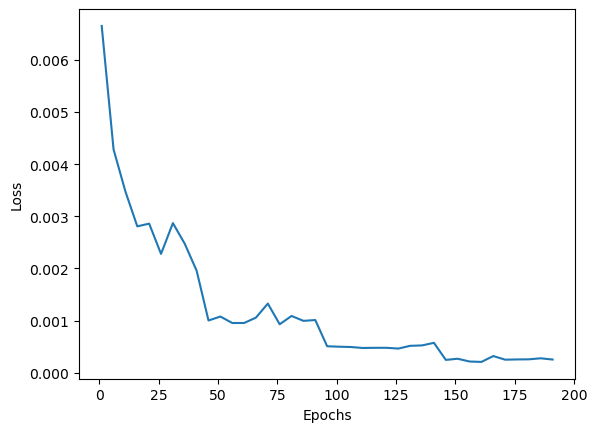

In [9]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");

In [10]:
model = SelfNetwork(input_dim).to(device)
model.load_state_dict(torch.load("self_interaction.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity(X_val[:,:9], X_val[:, 9:])

In [11]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(val_output, Y_val)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(Y_val).mean(axis=0))
print("RMSE:", err.mean()**.5, err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([2.3705e-04, 2.3615e-04, 3.8645e-04, 3.9007e-04, 3.9575e-04, 4.7771e-05],
       device='cuda:0')
Actual Magnitude:
  tensor([0.3423, 0.3406, 0.3690, 0.0513, 0.0518, 0.0766], device='cuda:0')
RMSE: tensor(0.0003, device='cuda:0') tensor(9.5393e-08, device='cuda:0')


In [12]:
#### Mean Relative Absolute Error
valid_mask = torch.abs(Y_val) > 1e-6

filtered_y_tensor = torch.where(valid_mask, Y_val, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)

a = torch.nanmean(relative_error, dim=0)
a*100

tensor([0.0657, 0.0623, 0.0783, 0.9752, 0.9666, 0.0596], device='cuda:0')

In [13]:
frac = rmse/torch.abs(Y_val).mean(axis=0)
frac*100

tensor([0.0693, 0.0693, 0.1047, 0.7597, 0.7641, 0.0624], device='cuda:0')

In [13]:
ii = 124
Y_val[ii], val_output[ii], X_val[ii,:3]

(tensor([-0.6538,  0.1598,  0.7396, -0.1169, -0.1135,  0.2519], device='cuda:0'),
 tensor([-0.6539,  0.1598,  0.7362, -0.1168, -0.1134,  0.2517], device='cuda:0'),
 tensor([1., 1., 1.], device='cuda:0'))